In [ ]:
#Import required library

import json
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from google.colab import files
from sklearn.metrics import mean_absolute_error as MAE

In [ ]:
#Upload the buy prices of the gold dataset

print('Please upload the buy prices of the gold: ')
f_buy = files.upload()
for key in f_buy:
  f_buy_name = key
with open(f_buy_name, 'r') as f:
  buy = np.array(json.loads(f.read()))

Please upload the buy prices of the gold: 


Saving Scraping-Harga-Beli-Emas-Indogold.txt to Scraping-Harga-Beli-Emas-Indogold.txt


In [ ]:
#Upload the sell prices of the gold dataset

print('Please upload the sell prices of the gold: ')
f_sell = files.upload()
for key in f_sell:
  f_sell_name = key
with open(f_sell_name, 'r') as f:
  sell = np.array(json.loads(f.read()))

Please upload the sell prices of the gold: 


Saving Scraping-Harga-Jual-Emas-Indogold.txt to Scraping-Harga-Jual-Emas-Indogold.txt


In [ ]:
#Compare the buy and sell dates dataset, if true, we can continue

comparison = buy[:,0] == sell[:,0]
comparison.all()

True

In [ ]:
#Stack the buy and sell prices

np_buy_sell = np.hstack([buy[:,:2], np.expand_dims(sell[:,1], axis=1)])
np_buy_sell

array([[1550707200000,        632139,        607000],
       [1550793600000,        629617,        605000],
       [1550880000000,        627599,        603000],
       ...,
       [1645142400000,        897506,        861500],
       [1645228800000,        899524,        864000],
       [1645315200000,        899524,        864000]])

In [ ]:
#Buikld the dataframe

df = pd.DataFrame(np_buy_sell, columns=['date', 'buy_price', 'sell_price'])
df

,date,buy_price,sell_price
0,1550707200000,632139,607000
1,1550793600000,629617,605000
2,1550880000000,627599,603000
3,1550966400000,629112,604500
4,1551052800000,626590,602000
...,...,...,...
1091,1644969600000,893470,858500
1092,1645056000000,903560,867500
1093,1645142400000,897506,861500
1094,1645228800000,899524,864000


In [ ]:
#Parse the unix into readable dates

df['date'] = df['date']/1000
df['date'] = pd.to_datetime(df['date'], unit='s')
df

,date,buy_price,sell_price
0,2019-02-21,632139,607000
1,2019-02-22,629617,605000
2,2019-02-23,627599,603000
3,2019-02-24,629112,604500
4,2019-02-25,626590,602000
...,...,...,...
1091,2022-02-16,893470,858500
1092,2022-02-17,903560,867500
1093,2022-02-18,897506,861500
1094,2022-02-19,899524,864000


## Data Pre-processing


In [ ]:
#Function for plotting, windowing, min-max scaling, and min-max denormalization

def plot_function(time_step, series, title, xlabel, ylabel, label, grid=False):
    plt.plot(time_step, series, '-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(label, loc ="upper left")
    plt.grid(grid)

def window_dataset(series, seq):
    x = []
    y = []
    for i in range(len(series) - seq - 1):
        temp_x = series[i:(i + seq)]
        temp_y = series[(i + seq)]
        x.append(temp_x)
        y.append(temp_y)
    return np.array(x), np.array(y)

def min_max_scaler(series):
    scaled_dataset = np.array([])
    min = np.min(series, axis=0)
    max = np.max(series, axis=0)
    for i in series:
      series_std = (i - min) / (max - min)
      if scaled_dataset.size == 0:
        scaled_dataset = series_std
      else:
        scaled_dataset = np.vstack((scaled_dataset, series_std))
    return scaled_dataset

def data_denormalization(series, normalized_data):
  denormalized_data = np.array([])
  min = np.min(series, axis=0)
  max = np.max(series, axis=0)
  for i in normalized_data:
    series_denormalized = i * (max - min) + min
    if denormalized_data.size == 0:
      denormalized_data = series_denormalized
    else:
      denormalized_data = np.vstack((denormalized_data, series_denormalized))
  return denormalized_data

In [ ]:
#Preprocess the dataset

print("Description of the Dataset: \n", df.describe())
df2 = pd.DataFrame()
for i in df.columns:
  if i != "date":
    df2[i+"_normalized"] = df[i].copy()
    df2[i+"_normalized"] = pd.to_numeric(df2[i+"_normalized"], downcast='float')

label_df = df.columns[1:].to_list()

price = df2.to_numpy(copy=True)

print("\nValues of dataset: \n", df.iloc[:,1:])

time_step = np.array([i for i in range(price.shape[0])])

data_training = min_max_scaler(price)

for i in range(data_training.shape[1]):
  df2.iloc[:,i] = data_training[:,i]

print("\nNormalized dataset: \n", df2)

Description of the Dataset: 
           buy_price     sell_price
count  1.096000e+03    1096.000000
mean   8.160332e+05  783326.642336
std    1.064027e+05  103076.433767
min    6.069140e+05  583000.000000
25%    7.122288e+05  680500.000000
50%    8.672360e+05  833000.000000
75%    8.853980e+05  851000.000000
max    1.004965e+06  965500.000000

Values of dataset: 
       buy_price  sell_price
0        632139      607000
1        629617      605000
2        627599      603000
3        629112      604500
4        626590      602000
...         ...         ...
1091     893470      858500
1092     903560      867500
1093     897506      861500
1094     899524      864000
1095     899524      864000

[1096 rows x 2 columns]

Normalized dataset: 
       buy_price_normalized  sell_price_normalized
0                 0.063371               0.062745
1                 0.057035               0.057516
2                 0.051966               0.052288
3                 0.055767               0.056209

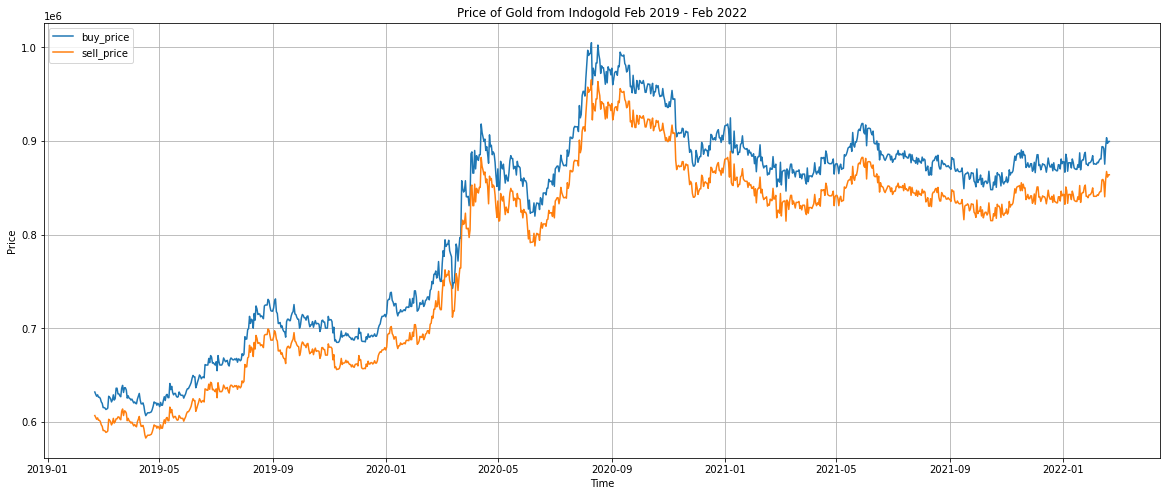

In [ ]:
#Plot the dataset

plt.figure(figsize=(20, 8))
plot_function(time_step=df['date'], series=price, 
              title='Price of Gold from Indogold Feb 2019 - Feb 2022',
              xlabel='Time', ylabel='Price', label=label_df, grid=True)
plt.show()

In [ ]:
#Split the dataset into 80% of training and 20% of testing and convert it to tensor
seq = 30
x, y = window_dataset(data_training, seq)
print('\nData Training: \n', data_training[:30])
print('\nX: \n', x[-1])
print('\nY: \n', y[-1])

train_size = int(len(y) * 0.8)

tensor_x = torch.Tensor(np.array(x)).requires_grad_(True)
tensor_y = torch.Tensor(np.array(y)).requires_grad_(True)

train_x = torch.Tensor(np.array(x[:train_size])).requires_grad_(True)
train_y = torch.Tensor(np.array(y[:train_size])).requires_grad_(True)

test_x = torch.Tensor(np.array(x[train_size:])).requires_grad_(True)
test_y = torch.Tensor(np.array(y[train_size:])).requires_grad_(True)


Data Training: 
 [[0.06337128 0.0627451 ]
 [0.05703541 0.05751634]
 [0.0519657  0.05228758]
 [0.05576672 0.05620915]
 [0.04943085 0.0496732 ]
 [0.04943085 0.0496732 ]
 [0.04562732 0.04575163]
 [0.0367566  0.03660131]
 [0.03295306 0.03267974]
 [0.02154749 0.02091503]
 [0.02154749 0.02091503]
 [0.02027881 0.01960784]
 [0.01647779 0.01568628]
 [0.01774396 0.01699346]
 [0.02027881 0.01960784]
 [0.0519657  0.05228758]
 [0.04943085 0.0496732 ]
 [0.04562732 0.04575163]
 [0.0367566  0.03660131]
 [0.0418263  0.04183007]
 [0.05576672 0.05490196]
 [0.0418263  0.04183007]
 [0.04562732 0.04575163]
 [0.07351068 0.05359477]
 [0.07351068 0.05359477]
 [0.05830158 0.05882353]
 [0.05830158 0.05882353]
 [0.05323187 0.05359477]
 [0.05069702 0.05098039]
 [0.07351068 0.07450981]]

X: 
 [[0.65906125 0.65751636]
 [0.68187493 0.6810458 ]
 [0.6856785  0.68496734]
 [0.6856785  0.68496734]
 [0.70088756 0.7006536 ]
 [0.7059573  0.7058824 ]
 [0.6742704  0.6745098 ]
 [0.6742704  0.6745098 ]
 [0.67046934 0.67058825]


In [ ]:
#Split the dataset into 80% of training and 20% of testing and convert it to tensor (denormalized data)

x_denormalized, y_denormalized = window_dataset(price, seq)
print('\nData Training: \n', price[:30])
print('\nX: \n', x_denormalized[-1])
print('\nY: \n', y_denormalized[-1])

train_size_denormalized = int(len(y_denormalized) * 0.8)

tensor_x_denormalized = torch.Tensor(np.array(x_denormalized)).requires_grad_(True)
tensor_y_denormalized = torch.Tensor(np.array(y_denormalized)).requires_grad_(True)

train_x_denormalized = torch.Tensor(np.array(x_denormalized[:train_size_denormalized])).requires_grad_(True)
train_y_denormalized = torch.Tensor(np.array(y_denormalized[:train_size_denormalized])).requires_grad_(True)

test_x_denormalized = torch.Tensor(np.array(x_denormalized[train_size_denormalized:])).requires_grad_(True)
test_y_denormalized = torch.Tensor(np.array(y_denormalized[train_size_denormalized:])).requires_grad_(True)


Data Training: 
 [[632139. 607000.]
 [629617. 605000.]
 [627599. 603000.]
 [629112. 604500.]
 [626590. 602000.]
 [626590. 602000.]
 [625076. 600500.]
 [621545. 597000.]
 [620031. 595500.]
 [615491. 591000.]
 [615491. 591000.]
 [614986. 590500.]
 [613473. 589000.]
 [613977. 589500.]
 [614986. 590500.]
 [627599. 603000.]
 [626590. 602000.]
 [625076. 600500.]
 [621545. 597000.]
 [623563. 599000.]
 [629112. 604000.]
 [623563. 599000.]
 [625076. 600500.]
 [636175. 603500.]
 [636175. 603500.]
 [630121. 605500.]
 [630121. 605500.]
 [628103. 603500.]
 [627094. 602500.]
 [636175. 611500.]]

X: 
 [[869254. 834500.]
 [878335. 843500.]
 [879849. 845000.]
 [879849. 845000.]
 [885903. 851000.]
 [887921. 853000.]
 [875308. 841000.]
 [875308. 841000.]
 [873795. 839500.]
 [876822. 842500.]
 [876822. 842500.]
 [877831. 843500.]
 [879849. 845500.]
 [884389. 850000.]
 [875308. 841000.]
 [875813. 841000.]
 [875308. 841000.]
 [875308. 841000.]
 [877326. 842500.]
 [876822. 842000.]
 [879344. 844500.]
 [8808

In [ ]:
#Inspect the train and test shape

train_x.shape, test_x.shape

(torch.Size([852, 30, 2]), torch.Size([213, 30, 2]))

In [ ]:
#Build the model using torch.nn module

class GRU(nn.Module):

    def __init__(self, num_classes, input_size, gru_hidden_size, fc_hidden_size,
                 num_layers, seq_length):
        super(GRU, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.gru_hidden_size = gru_hidden_size
        self.fc_hidden_size = fc_hidden_size
        self.seq_length = seq_length
        self.gru = nn.GRU(input_size=input_size, hidden_size=fc_hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.batchnorm = nn.BatchNorm1d(fc_hidden_size)
        self.fc = nn.Linear(fc_hidden_size, out_features=num_classes)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        output_out, h_out = self.gru(x)
        batchnorm_output = self.batchnorm(h_out[0,:,:])
        linear_output = self.fc(batchnorm_output)
        sigmoid_output = self.sig(linear_output)

        return sigmoid_output


Begin training using GRU with Batch Normalization and Adam optimizer
----------------------------------------------------------------------
Epoch: 0, Loss: 0.06654, MAE: 0.33562, Time: 0.019 s
Epoch: 1, Loss: 0.05247, MAE: 0.28875, Time: 0.019 s
Epoch: 2, Loss: 0.02087, MAE: 0.18594, Time: 0.018 s
Epoch: 3, Loss: 0.01435, MAE: 0.15335, Time: 0.018 s
Epoch: 4, Loss: 0.00833, MAE: 0.11324, Time: 0.023 s
Epoch: 5, Loss: 0.00407, MAE: 0.07409, Time: 0.022 s
Epoch: 6, Loss: 0.00166, MAE: 0.04390, Time: 0.018 s
Epoch: 7, Loss: 0.00082, MAE: 0.03177, Time: 0.018 s
Epoch: 8, Loss: 0.00102, MAE: 0.03760, Time: 0.018 s
Epoch: 9, Loss: 0.00168, MAE: 0.04826, Time: 0.018 s
Epoch: 10, Loss: 0.00226, MAE: 0.05410, Time: 0.021 s
Epoch: 11, Loss: 0.00258, MAE: 0.05831, Time: 0.018 s
Epoch: 12, Loss: 0.00256, MAE: 0.05903, Time: 0.018 s
Epoch: 13, Loss: 0.00262, MAE: 0.05633, Time: 0.018 s
Epoch: 14, Loss: 0.00431, MAE: 0.08434, Time: 0.018 s
Epoch: 15, Loss: 0.00492, MAE: 0.09002, Time: 0.018 s
Epoch:

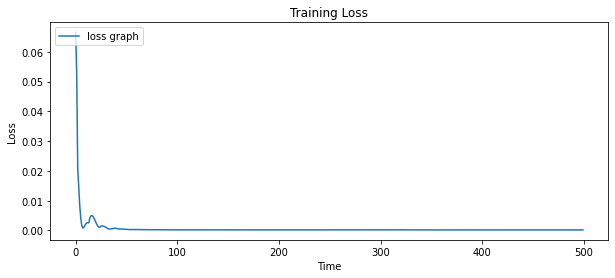

In [ ]:
#Train the model

seed = 23
torch.manual_seed(seed)
np.random.seed(seed)

num_epochs = 500
learning_rate = 0.1
momentum = 0.9

input_size = 2
gru_hidden_size = 4
fc_hidden_size = 4
num_layers = 1
num_classes = 2

model = GRU(num_classes, input_size, gru_hidden_size, 
            fc_hidden_size, num_layers, seq)

loss_func = nn.HuberLoss()
validator = True
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=25, verbose=True)

loss_list = []
mae_list = []
epochs = []
time_per_epoch = []
# Pelatihan model
print("Begin training using GRU with Batch Normalization and Adam optimizer")
print("-" * 70)
model.train()
for epoch in range(num_epochs):
    start = time.time()
    outputs = model(train_x)
    optimizer.zero_grad()
    loss = loss_func(outputs, train_y)
    mae = MAE(outputs.detach().numpy(), train_y.detach().numpy())
    loss.backward()
    scheduler.step(loss)
    optimizer.step()
    stop = time.time()
    epoch_time = stop - start
    loss_list.append(loss.item())
    mae_list.append(mae.item())
    epochs.append(epoch)
    time_per_epoch.append(epoch_time)
    print("Epoch: %d, Loss: %1.5f, MAE: %1.5f, Time: %1.3f s" % (epoch, loss.item(), mae.item(), epoch_time))

print("-" * 70)
print(model)

print("-" * 70)
print("Training done in %1.5f seconds with last training loss: %1.5f" % (sum(time_per_epoch), loss_list[-1]))
plt.figure(figsize=(10, 4))
plot_function(time_step=epochs, series=loss_list,
              title='Training Loss',
              xlabel='Time', ylabel='Loss', label=["loss graph"])

----------------------------------------------------------------------
Layer: GRU with Batch Normalization
Config: GRU with 4 Hidden Size
Optimizer: Adam
Training MAE: 0.01365 
Testing MAE: 0.01131 
Testing Denormalized MAE: 4414.02344


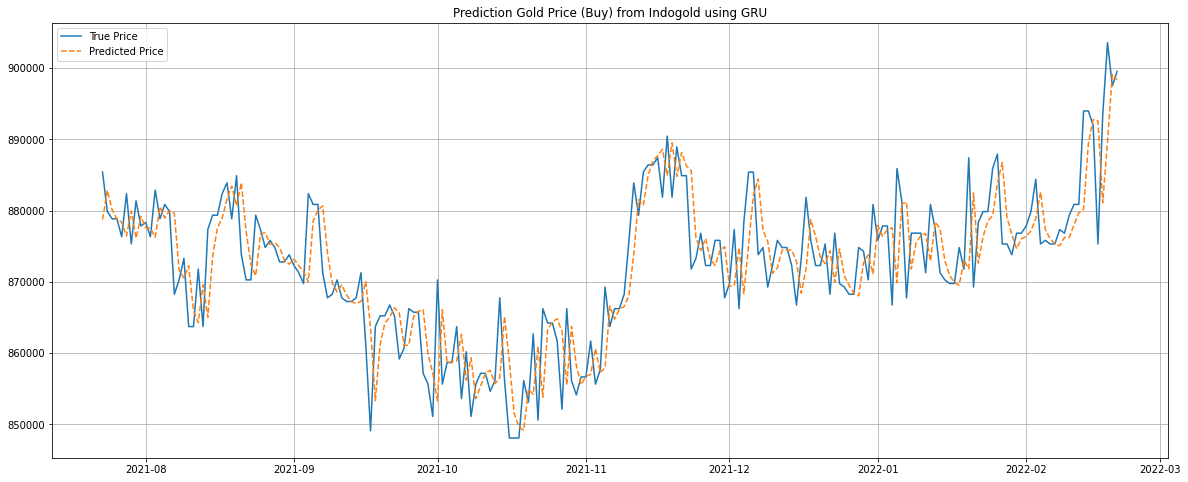

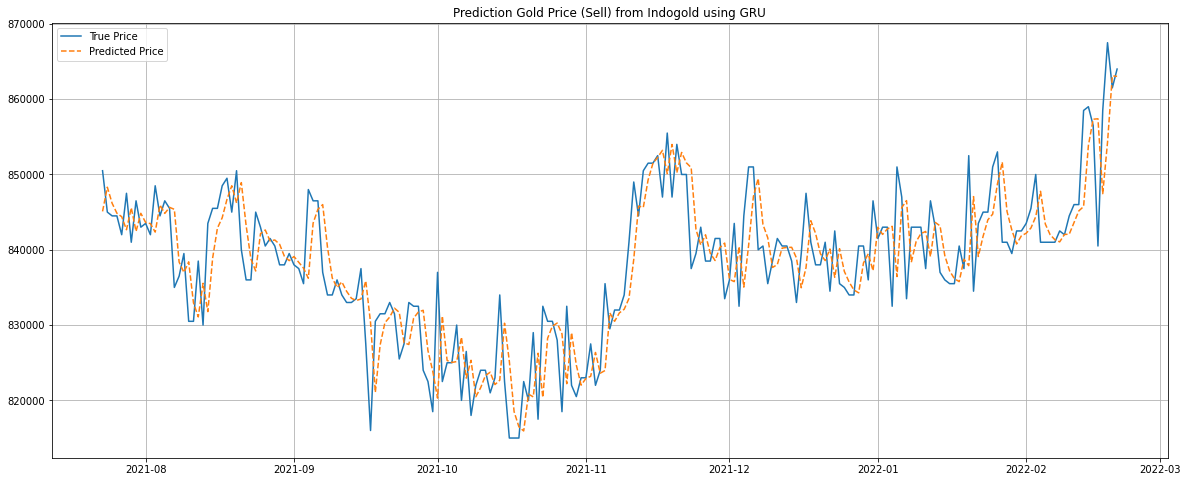

In [ ]:
#Evaluate the model

model.eval()
train_predict = model(test_x)

data_y_plot = test_y.data.numpy()
data_predict = train_predict.data.numpy()

data_predict_scale = data_denormalization(price, data_predict)

print("-" * 70)
print("Layer: GRU with Batch Normalization\nConfig: GRU with 4 Hidden Size\nOptimizer: Adam\nTraining MAE: %1.5f \nTesting MAE: %1.5f \nTesting Denormalized MAE: %1.5f" %
      (mae_list[-1], MAE(data_y_plot, data_predict), MAE(test_y_denormalized.detach().numpy(), data_predict_scale)))

torch.save(model.state_dict(), 'gru-gold-price.pth')

data_y_denormalized = test_y_denormalized.detach().numpy()

plt.figure(figsize=(20, 8))
plt.plot(df['date'][-213:], data_y_denormalized[:,:1])
plt.plot(df['date'][-213:], data_predict_scale[:,:1], '--')
plt.title('Prediction Gold Price (Buy) from Indogold using GRU')
plt.legend(['True Price', 'Predicted Price'], loc="upper left")
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(df['date'][-213:], data_y_denormalized[:,1:2])
plt.plot(df['date'][-213:], data_predict_scale[:,1:2], '--')
plt.title('Prediction Gold Price (Sell) from Indogold using GRU')
plt.legend(['True Price', 'Predicted Price'], loc="upper left")
plt.grid(True)
plt.show()

## Test the Saved Model

In [ ]:
#Import required library for test the saved model

import json
import datetime
import numpy as np
import torch
import torch.nn as nn
from google.colab import files
from sklearn.metrics import mean_absolute_error as MAE

In [ ]:
#Upload the model save dict

print('Please upload the model save dict: ')
f_model = files.upload()
for key in f_model:
  f_model_name = key

Please upload the model save dict: 


Saving gru-gold-price.pth to gru-gold-price.pth


In [ ]:
#Upload the min-max configuration

print('Please upload the min-max configuration: ')
f_config = files.upload()
for key in f_config:
  f_config_name = key

with open(f_config_name, 'r') as f:
  min_max = json.loads(f.read())

Please upload the min-max configuration: 


Saving min_max.json to min_max.json


In [ ]:
#Build the model

class GRU(nn.Module):

    def __init__(self, num_classes, input_size, gru_hidden_size, fc_hidden_size,
                 num_layers):
        super(GRU, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.gru_hidden_size = gru_hidden_size
        self.fc_hidden_size = fc_hidden_size
        self.gru = nn.GRU(input_size=input_size, hidden_size=fc_hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.batchnorm = nn.BatchNorm1d(fc_hidden_size)
        self.fc = nn.Linear(fc_hidden_size, out_features=num_classes)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        output_out, h_out = self.gru(x)
        batchnorm_output = self.batchnorm(h_out[0,:,:])
        linear_output = self.fc(batchnorm_output)
        sigmoid_output = self.sig(linear_output)

        return sigmoid_output


In [ ]:
#Define the min-max scaler and denormalization function

def min_max_scaler(series, minmax):
    scaled_dataset = np.array([])
    min = np.array(minmax['min'])
    max = np.array(minmax['max'])
    for i in series:
      series_std = (i - min) / (max - min)
      if scaled_dataset.size == 0:
        scaled_dataset = series_std
      else:
        scaled_dataset = np.vstack((scaled_dataset, series_std))
    return scaled_dataset

def data_denormalization(series, minmax):
  denormalized_data = np.array([])
  min = np.array(minmax['min'])
  max = np.array(minmax['max'])
  for i in series:
    series_denormalized = i * (max - min) + min
    if denormalized_data.size == 0:
      denormalized_data = series_denormalized
    else:
      denormalized_data = np.vstack((denormalized_data, series_denormalized))
  return denormalized_data

In [ ]:
#Declare the test and label

test = np.array([[880858.0, 846500.0],
 [879344.0, 845000.0],
 [881362.0, 847500.0],
 [883885.0, 849500.0],
 [885903.0, 852000.0],
 [885903.0, 852000.0],
 [885398.0, 851000.0],
 [879849.0, 846000.0],
 [883885.0, 850000.0],
 [877326.0, 843000.0],
 [879849.0, 845500.0],
 [880858.0, 846500.0],
 [880858.0, 846500.0],
 [885903.0, 851500.0],
 [885903.0, 851500.0],
 [889939.0, 855000.0],
 [884894.0, 850000.0],
 [886407.0, 851500.0],
 [885398.0, 850500.0],
 [885398.0, 850500.0],
 [886912.0, 852500.0],
 [881362.0, 847000.0],
 [889434.0, 854500.0],
 [883380.0, 848500.0],
 [883380.0, 849000.0],
 [881867.0, 847000.0],
 [881867.0, 847000.0],
 [885903.0, 851000.0],
 [885903.0, 851000.0],
 [876822.0, 842000.0]])

true = np.array([885398.0, 850500.0])

In [ ]:
#Preprocess the test data

test_norm = min_max_scaler(test, min_max)
tensor_test_norm = torch.Tensor(test_norm).requires_grad_(True)
tensor_test_norm = torch.unsqueeze(tensor_test_norm, 0)
tensor_test_norm

tensor([[[0.6882, 0.6889],
         [0.6844, 0.6850],
         [0.6895, 0.6915],
         [0.6958, 0.6967],
         [0.7009, 0.7033],
         [0.7009, 0.7033],
         [0.6996, 0.7007],
         [0.6857, 0.6876],
         [0.6958, 0.6980],
         [0.6793, 0.6797],
         [0.6857, 0.6863],
         [0.6882, 0.6889],
         [0.6882, 0.6889],
         [0.7009, 0.7020],
         [0.7009, 0.7020],
         [0.7110, 0.7111],
         [0.6984, 0.6980],
         [0.7022, 0.7020],
         [0.6996, 0.6993],
         [0.6996, 0.6993],
         [0.7034, 0.7046],
         [0.6895, 0.6902],
         [0.7098, 0.7098],
         [0.6945, 0.6941],
         [0.6945, 0.6954],
         [0.6907, 0.6902],
         [0.6907, 0.6902],
         [0.7009, 0.7007],
         [0.7009, 0.7007],
         [0.6781, 0.6771]]], grad_fn=<UnsqueezeBackward0>)

In [ ]:
#Instantiate the model using model save dict

input_size = 2
gru_hidden_size = 4
fc_hidden_size = 4
num_layers = 1
num_classes = 2

model = GRU(num_classes, input_size, gru_hidden_size, 
            fc_hidden_size, num_layers)
model.load_state_dict(torch.load(f_model_name))

<All keys matched successfully>

In [ ]:
#Predict the test data

model.eval()
test_pred = model(tensor_test_norm)
test_pred_norm = data_denormalization(test_pred.detach().numpy(), min_max)

In [ ]:
#Print the true and predicted, also the MAE

print('True price: ', true)
print('Predicted price', test_pred_norm.round())
print('MAE: ', MAE(true,test_pred_norm))

True price:  [885398. 850500.]
Predicted price [878725. 845097.]
MAE:  6037.95037651062


In [ ]:
#Print the price difference

buy = round(true[0] - test_pred_norm[0])
sell = round(true[1] - test_pred_norm[1])
print('Buy price difference: ', buy)
print('Sell price difference: ', sell)

Buy price difference:  6673
Sell price difference:  5403
